# Open Set detection using naive logistic regression on MNIST digits classification
In this project we are going to use the naive logistic regression method for an open set detection task on the MNIST data set, we split the $0-9$ digits into two parts. The first part is $0-5$,and it is used  in the training and testing set,and the second part is $6-9$,it is used only in the testing set. The goal for this project is that the model can correctly classify the known class in $0-5$ and it can also tell $6-9$ from the known class.

## Importing and preprocessing data

In [7]:
#loading needed library
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from scipy.io import loadmat
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

#Loading the MNIST data set
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0].astype(int)
#mnist_label
#mnist_data

#normalize data
def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std
    return data_normalized
mnist_data_normalized = normalize(mnist_data)

#split the class
known_class = [0,1,2,3,4,5]
unknown_class = [6,7,8,9]
mnist_data_known = []
mnist_label_known = []
mnist_data_unknown = []
mnist_label_unknown = []
for i in range(len(mnist_data_normalized)):
    if(mnist_label[i] in known_class):
        mnist_data_known.append(mnist_data_normalized[i])
        mnist_label_known.append(mnist_label[i])
    else:
        mnist_data_unknown.append(mnist_data_normalized[i])
        mnist_label_unknown.append(mnist_label[i])
mnist_data_known = np.array(mnist_data_known)
mnist_data_unknown = np.array(mnist_data_unknown)
#mnist_data_known 
mnist_label_known = np.array(mnist_label_known)
mnist_label_unknown = np.array(mnist_label_unknown)
#mnist_label_unknown

#spliting into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data_known,mnist_label_known, test_size=0.20, random_state=42)
X_test_with_unknown = np.vstack((X_test,mnist_data_unknown))
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test_with_unknown = np.hstack((Y_test,mnist_label_unknown))
Y_test = Y_test.reshape(Y_test.shape[0],1)
Y_test_with_unknown = Y_test_with_unknown.reshape(Y_test_with_unknown.shape[0],1)
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

# Creating new training label vectors for each digit for the one-vs-all methode
Y_train_0=(Y_train==0).astype(int)
Y_train_1=(Y_train==1).astype(int)
Y_train_2=(Y_train==2).astype(int)
Y_train_3=(Y_train==3).astype(int)
Y_train_4=(Y_train==4).astype(int)
Y_train_5=(Y_train==5).astype(int)
# Y_train_6=(Y_train==6).astype(int)
# Y_train_7=(Y_train==7).astype(int)
# Y_train_8=(Y_train==8).astype(int)
# Y_train_9=(Y_train==9).astype(int)

# Creating new testing label vectors for each digit for the one-vs-all methode
Y_test_0=(Y_test==0).astype(int)
Y_test_1=(Y_test==1).astype(int)
Y_test_2=(Y_test==2).astype(int)
Y_test_3=(Y_test==3).astype(int)
Y_test_4=(Y_test==4).astype(int)
Y_test_5=(Y_test==5).astype(int)
Y_test_6=(Y_test==6).astype(int)
Y_test_7=(Y_test==7).astype(int)
Y_test_8=(Y_test==8).astype(int)
Y_test_9=(Y_test==9).astype(int)

The shape of the training set feature matrix is: (33638, 784)
The shape of the training label vector is: (33638, 1)
The shape of the test set feature matrix is: (8410, 784)
The shape of the test label vector is: (8410, 1)


## Creating model functions

In [8]:
# Creating initilizer function to initialize weights and bias
def initializer(nbr_features):
    W = np.zeros((nbr_features,1))
    B = 0
    return W, B

# Creating a Sigmoid function
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

# Creating the Forward and backward propagation function which calculates J, dW, and dB
def ForwardBackProp(X, Y, W, B):
    m = X.shape[0] 
    dw = np.zeros((W.shape[0],1))
    dB = 0
    
    Z = np.dot(X,W)+B
    Yhat = sigmoid(Z) 
    J = -(1/m)*(np.dot(Y.T,np.log(Yhat))+np.dot((1-Y).T,np.log(1-Yhat)))
    dW = (1/m)*np.dot(X.T,(Yhat-Y))
    dB = (1/m)*np.sum(Yhat-Y)
    return J, dW, dB

# Creating a prediction function which predicts the labels of the input images
def predict(X,W,B):
    Yhat_prob = sigmoid(np.dot(X,W)+B)
    score = np.dot(X,W) + B
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob ,score

# Creating the gradient descent optimizer function
def gradient_descent(X, Y, W, B, alpha, max_iter):
    i=0
    RMSE = 1
    cost_history=[]
    
    # setup toolbar
    toolbar_width = 20
    sys.stdout.write("[%s]" % ("" * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
    
    while (i<max_iter)&(RMSE>10e-6):
        J, dW, dB = ForwardBackProp(X,Y,W,B)
        W = W - alpha*dW
        B = B - alpha*dB
        cost_history.append(J)
        Yhat, _ , _ = predict(X,W,B)
        RMSE = np.sqrt(np.mean(Yhat-Y)**2)
        i+=1
        if i%50==0:
            sys.stdout.write("=")
            sys.stdout.flush()
    
    sys.stdout.write("]\n") # this ends the progress bar
    return cost_history, W, B, i

# Creating the model function which trains a model and return its parameters. 
def LogRegModel(X_train, Y_train, alpha, max_iter):
    
    nbr_features = X_train.shape[1]
    W, B = initializer(nbr_features)
    cost_history, W, B, i = gradient_descent(X_train, Y_train, W, B, alpha, max_iter)
    Yhat_train, _ , _ = predict(X_train, W, B)
    #Yhat, _ = predict(X_test, W, B)
    
    train_accuracy = accuracy_score(Y_train, Yhat_train)
    #test_accuracy = accuracy_score(Y_test, Yhat)
    #conf_matrix = confusion_matrix(Y_test, Yhat, normalize='true')
    
    model = {"weights": W,
            "bias": B,
            "train_accuracy": train_accuracy,
            #"test_accuracy": test_accuracy,
            #"confusion_matrix": conf_matrix,
            "cost_history": cost_history}
    return model



## Training Model

In [9]:
# Creating and training a model for each digit

models_list=[]
models_name_list=['model_0','model_1','model_2','model_3','model_4','model_5','model_6',
                 'model_7','model_8','model_9']
Y_train_list=[Y_train_0,Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5]
Y_test_list = [Y_test_0,Y_test_1,Y_test_2,Y_test_3,Y_test_4,Y_test_5,Y_test_6,Y_test_7,
              Y_test_8,Y_test_9]
print('Training of a classifier for each digit:')
for i in range(5):
    print('Training of the model: ', models_name_list[i],', to recognize the digit: ',i)
    print('Training progress bar: 1 step each 50 iteration')
    model = LogRegModel(X_train, Y_train_list[i], alpha=0.01, max_iter=1000)
    print('Training completed!')
    print('Train Accuracy:', model['train_accuracy'])
    print('-'*60)
    models_list.append(model)

Training of a classifier for each digit:
Training of the model:  model_0 , to recognize the digit:  0
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Train Accuracy: 0.9877816754860574
------------------------------------------------------------
Training of the model:  model_1 , to recognize the digit:  1
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Train Accuracy: 0.9884356977228135
------------------------------------------------------------
Training of the model:  model_2 , to recognize the digit:  2
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Train Accuracy: 0.9689042154705987
------------------------------------------------------------
Training of the model:  model_3 , to recognize the digit:  3
Training progress bar: 1 step each 50 iteration
[====================]
Training completed!
Train Accuracy: 0.9590046970687912
----------------------------

## Prediction

In [47]:
# Creating a one-vs-all function that uses all the trained models to predict the label of a random image
def one_vs_all(data, models_list):
    pred_matrix = np.zeros((data.shape[0],6))
    score_matrix = np.zeros((data.shape[0],6))
    for i in range(len(models_list)):
        W = models_list[i]['weights']
        B = models_list[i]['bias']
        Yhat, Yhat_prob , score = predict(data,W,B)
        pred_matrix[:,i] = Yhat_prob.T
        score_matrix[:,i] = score.T
    max_prob_vec = np.amax(pred_matrix, axis=1, keepdims=True)
    #print(max_prob_vec)
    #print(max_prob_vec.shape)
    max_score_vec = np.amax(score_matrix, axis=1,keepdims=True)
    #print(max_score_vec)
    pred_matrix_max_prob = (pred_matrix == max_prob_vec).astype(int)
    #print( pred_matrix_max_prob)
    #print(pred_matrix_max_prob.shape[0])
    labels=[]
    for j in range(pred_matrix_max_prob.shape[0]):
        idx = np.where(pred_matrix_max_prob[j,:]==1)
        if(max_score_vec[j] < 1.4):
            labels.append(-1)
        else:
            labels.append(idx)
    labels = np.vstack(labels).flatten()
    #print(labels)
    return labels
pred_label = one_vs_all(X_test, models_list)
correct = 0.0
for i in range(len(X_test)):
    if(pred_label[i] == Y_test[i]):
        correct += 1
accuarcy = correct / len(pred_label)
print("The accuarcy on test set without unknown class is:",accuarcy)
correct = 0.0
pred_label = one_vs_all(X_test_with_unknown, models_list)
for i in range(len(X_test_with_unknown)):
    if(Y_test_with_unknown[i] in known_class):
        if(pred_label[i] == Y_test_with_unknown[i]):
            correct += 1
    else:
        if(pred_label[i] == -1):
            correct += 1
accuarcy = correct / len(pred_label)
print("The accuarcy on test set with unknown class is:",accuarcy)

The accuarcy on test set without unknown class is: 0.7152199762187872
The accuarcy on test set with unknown class is: 0.7176722952532864


## Draw Plots

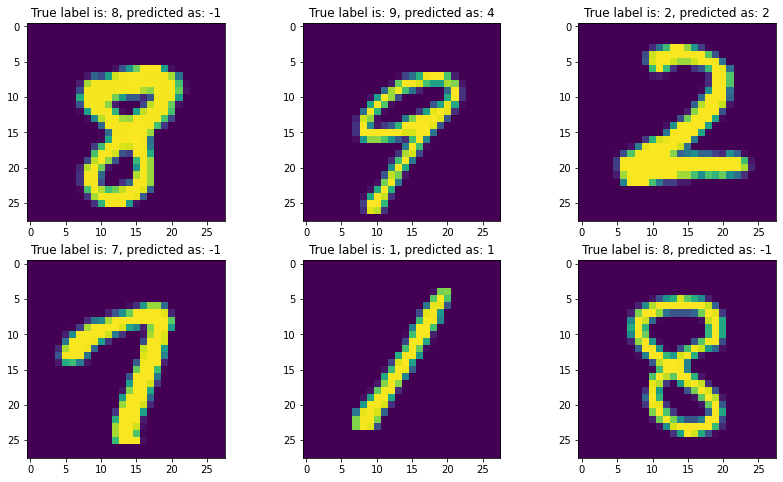

In [53]:
examples_number = 6 
index_random_sample = np.random.randint(70000, size=(1,examples_number))
example = mnist_data_normalized[index_random_sample].reshape(examples_number ,784)
true_labels = mnist_label[index_random_sample].flatten().astype(int)
label = one_vs_all(example, models_list)
image_size_px = int(np.sqrt(mnist_data.shape[1]))
# Viewing results 
plt.figure(figsize=(14,8))
for i in range(examples_number):
    image = example[i].reshape(image_size_px,image_size_px)
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    title = f"True label is: {true_labels[i]}, predicted as: {label[i]}"
    plt.title(title)